<a href="https://colab.research.google.com/github/suarez-duran-m/personal_projects/blob/main/movility/medellin/analysis_accidents_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysing Medellín car accident report

In [1]:
import folium, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt

%matplotlib inline
from IPython.display import Image, HTML

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN

In [2]:
data = pd.read_csv('data/crashes_georef_2020_to_2022.csv')

In [3]:
data.head()

,HORA,DIA_NOMBRE,PERIODO,CLASE,DIRECCION,TIPO_GEOCOD,GRAVEDAD,DISENO,MES,DIA,FECHA,MES_NOMBRE,LONGITUD,LATITUD
0,01:35:00,MIÉRCOLES,2020,Choque,CL 10 A CR 41,Malla vial,CON HERIDOS,Tramo de via,7,1,2020/07/01 00:00:00+00,JULIO,-75.568507,6.210703
1,11:30:00,VIERNES,2020,Choque,CR 38 CL 49 A,Malla vial,SOLO DAÑOS,Tramo de via,5,8,2020/05/08 00:00:00+00,MAYO,-75.558959,6.244545
2,08:25:00,LUNES,2020,Otro,CR 57 CL 51,Malla vial,SOLO DAÑOS,Tramo de via,10,19,2020/10/19 00:00:00+00,OCTUBRE,-75.575041,6.253081
3,06:30:00,MIÉRCOLES,2020,Choque,CL 5 CR 47,No Ubicada,CON HERIDOS,Interseccion,7,15,2020/07/15 00:00:00+00,JULIO,-75.703816,6.221806
4,02:00:00,DOMINGO,2020,Choque,CR 62 CL 50,Malla vial,CON HERIDOS,Tramo de via,4,5,2020/04/05 00:00:00+00,ABRIL,-75.576423,6.253848


In [4]:
data.describe()

,PERIODO,MES,DIA,LONGITUD,LATITUD
count,95916.000000,95916.000000,95916.000000,95916.000000,95916.000000
mean,2020.914894,6.024501,15.627288,-75.587260,6.249369
std,0.754643,3.452193,8.689897,0.040368,0.028340
min,2020.000000,1.000000,1.000000,-75.703816,6.166775
25%,2020.000000,3.000000,8.000000,-75.593084,6.227359
50%,2021.000000,6.000000,16.000000,-75.575648,6.249114
75%,2021.000000,9.000000,23.000000,-75.564802,6.271089
max,2022.000000,12.000000,31.000000,-75.490257,6.368358


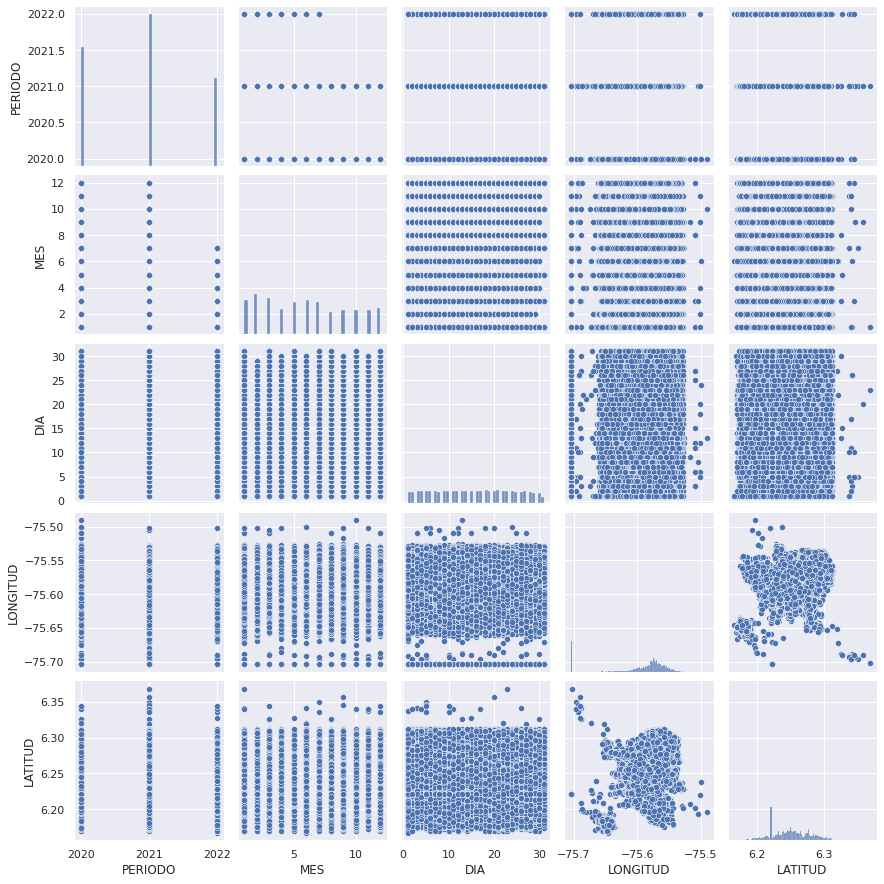

In [5]:
#cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'SalePrice']
sns.set()
sns.pairplot(data)

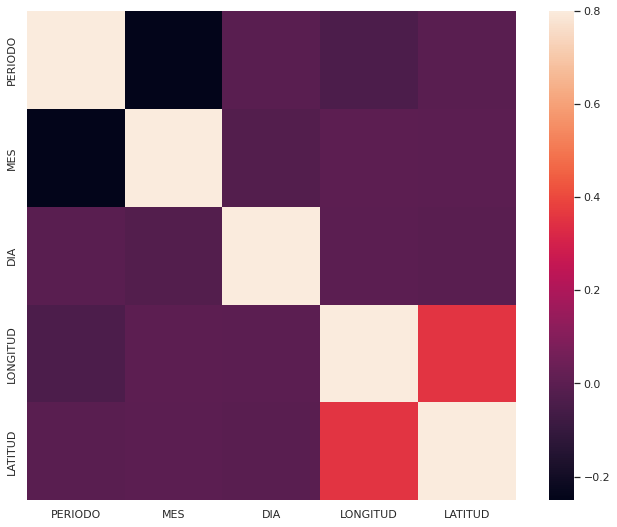

In [6]:
#correlation matrix
corrmat = data.corr(numeric_only = True)
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [5]:
tmp_df = data[['LATITUD', 'LONGITUD']].copy()
# Chosing only accidents occurred closeby to Medellin
tmp_df = tmp_df[(tmp_df['LATITUD'] > 6.222)]

In [6]:
print(tmp_df['LATITUD'].describe())
print("\n", tmp_df['LONGITUD'].describe())

count    74395.000000
mean         6.260267
std          0.021559
min          6.222001
25%          6.243650
50%          6.256919
75%          6.276183
max          6.368358
Name: LATITUD, dtype: float64

 count    74395.000000
mean       -75.575104
std          0.018924
min        -75.701639
25%        -75.586089
50%        -75.573109
75%        -75.562324
max        -75.500205
Name: LONGITUD, dtype: float64


Calculating the number of bins for a resolution of ~111$\,$m

In [7]:
(6.3683-6.2220) / 0.001

146.29999999999922

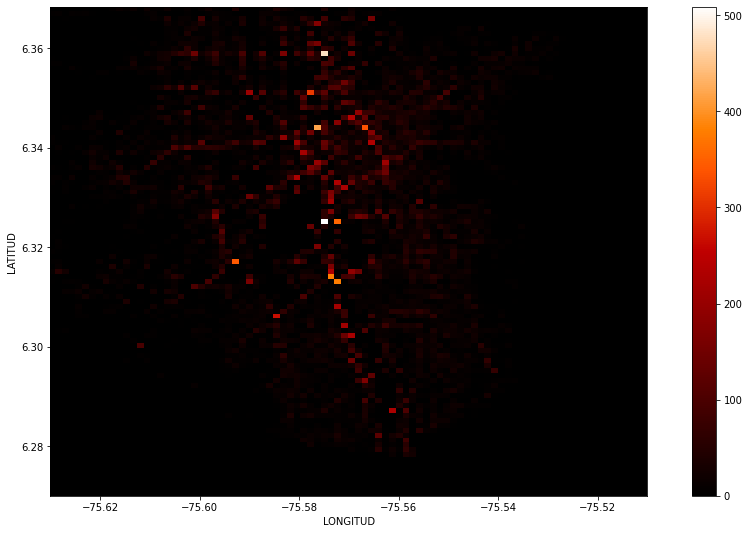

In [8]:
# Create a 2D histogram
n_bins = 147
hist, x_lon, y_lat = np.histogram2d(tmp_df['LONGITUD'].values, tmp_df['LATITUD'].values, bins=(n_bins, n_bins))
hist = hist.T

# Plot the 2D histogram
plt.figure(figsize=(16, 9))
plt.imshow(hist, interpolation='nearest', extent=[x_lon[0], x_lon[-1], y_lat[0], y_lat[-1]], 
           cmap = 'gist_heat')

plt.colorbar()
plt.xlim(xmin = -75.63, xmax = -75.51)
plt.ylim(ymin = 6.27)
plt.xlabel('LONGITUD')
plt.ylabel('LATITUD')
plt.grid(False)

plt.show()

In [9]:
highest = []

for lat_i in range(hist.shape[0]):
  for lon_i in range(hist.shape[1]):
    if hist[lat_i, lon_i] > 2.0e2:
      highest.append([lat_i, lon_i, hist[lat_i, lon_i]])

In [10]:
highest = np.array(highest)
print("Total accidents:", hist.sum())

sorted_indices = np.argsort(highest[:, 2])
sorted_data = highest[sorted_indices][::-1]
sorted_data

Total accidents: 74395.0


array([[ 43.,  92., 509.],
       [  9.,  92., 479.],
       [ 24.,  91., 418.],
       [ 55.,  94., 379.],
       [ 54.,  93., 379.],
       [ 43.,  94., 357.],
       [ 51.,  79., 342.],
       [ 24.,  98., 335.],
       [ 17.,  90., 312.],
       [ 62.,  85., 268.],
       [ 22.,  96., 242.],
       [ 35.,  94., 234.],
       [ 27.,  99., 232.],
       [ 34.,  88., 230.],
       [ 53.,  93., 229.],
       [ 81., 102., 227.],
       [ 66.,  96., 224.],
       [ 36.,  95., 223.],
       [ 29.,  89., 219.],
       [ 60.,  94., 219.],
       [ 39.,  93., 213.],
       [ 64.,  95., 212.],
       [ 27.,  88., 210.],
       [ 31., 101., 209.],
       [ 17.,  81., 207.],
       [ 31.,  91., 201.]])

In [11]:
# Normalizing
sorted_norm = sorted_data.copy()
sorted_norm[:, 2] = 100. * sorted_data[:, 2] / hist.sum()
sorted_norm = np.column_stack((sorted_norm, sorted_data[:, 2]))

sorted_norm = np.around(sorted_norm, decimals = 2)
sorted_norm

array([[4.30e+01, 9.20e+01, 6.80e-01, 5.09e+02],
       [9.00e+00, 9.20e+01, 6.40e-01, 4.79e+02],
       [2.40e+01, 9.10e+01, 5.60e-01, 4.18e+02],
       [5.50e+01, 9.40e+01, 5.10e-01, 3.79e+02],
       [5.40e+01, 9.30e+01, 5.10e-01, 3.79e+02],
       [4.30e+01, 9.40e+01, 4.80e-01, 3.57e+02],
       [5.10e+01, 7.90e+01, 4.60e-01, 3.42e+02],
       [2.40e+01, 9.80e+01, 4.50e-01, 3.35e+02],
       [1.70e+01, 9.00e+01, 4.20e-01, 3.12e+02],
       [6.20e+01, 8.50e+01, 3.60e-01, 2.68e+02],
       [2.20e+01, 9.60e+01, 3.30e-01, 2.42e+02],
       [3.50e+01, 9.40e+01, 3.10e-01, 2.34e+02],
       [2.70e+01, 9.90e+01, 3.10e-01, 2.32e+02],
       [3.40e+01, 8.80e+01, 3.10e-01, 2.30e+02],
       [5.30e+01, 9.30e+01, 3.10e-01, 2.29e+02],
       [8.10e+01, 1.02e+02, 3.10e-01, 2.27e+02],
       [6.60e+01, 9.60e+01, 3.00e-01, 2.24e+02],
       [3.60e+01, 9.50e+01, 3.00e-01, 2.23e+02],
       [2.90e+01, 8.90e+01, 2.90e-01, 2.19e+02],
       [6.00e+01, 9.40e+01, 2.90e-01, 2.19e+02],
       [3.90e+01, 9.

In [12]:
# Create a map centered on a specific location
map = folium.Map(location = [y_lat[int(sorted_norm[0, 0])], x_lon[int(sorted_norm[0, 1])]], zoom_start=13)

# Add markers for each event

for i in sorted_norm:  
  if int(i[0]) == int(sorted_norm[0, 0]) and int(i[1]) == int(sorted_norm[0, 1]):    
    folium.Marker(location=[y_lat[int(i[0])], x_lon[int(i[1])]], 
                  popup=f"Area with the Highest % {i[2]} %\n No. Accidents: {int(i[3])}",
                  icon=folium.Icon(color='red', icon='info-sign')
                 ).add_to(map)

  else:
    folium.Marker(location=[y_lat[int(i[0])], x_lon[int(i[1])]], 
                  popup=f"% of accidents in this area: {i[2]} %\n No. Accidents: {int(i[3])}",
                  icon=folium.Icon(color='blue', icon='info-sign')
                  ).add_to(map)
map

In [13]:
x_lonHighest = []
y_latHighest = []
for i in sorted_norm[:, 1]:
  x_lonHighest.append(x_lon[int(i)])
for i in sorted_norm[:, 0]:
  y_latHighest.append(y_lat[int(i)])

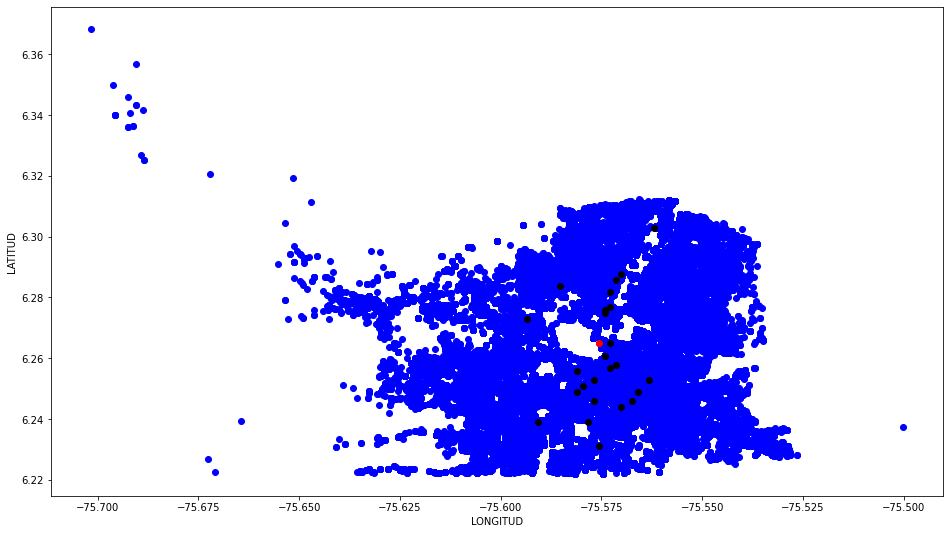

In [14]:
plt.figure(figsize=(16, 9))

plt.scatter(tmp_df['LONGITUD'], tmp_df['LATITUD'], color="blue", label="class 0")
plt.scatter(x_lonHighest, y_latHighest, color = "black")
plt.scatter(x_lonHighest[0], y_latHighest[0], color = "red")

plt.xlabel('LONGITUD')
plt.ylabel('LATITUD')
plt.show()

In [15]:
x_LatLon = np.array(tmp_df[['LONGITUD', 'LATITUD']].values.tolist())

clusters = 5
km_model = KMeans(n_clusters = clusters, n_init=5)
y_pred = km_model.fit_predict(x_LatLon)

cluster_centers = km_model.cluster_centers_ 

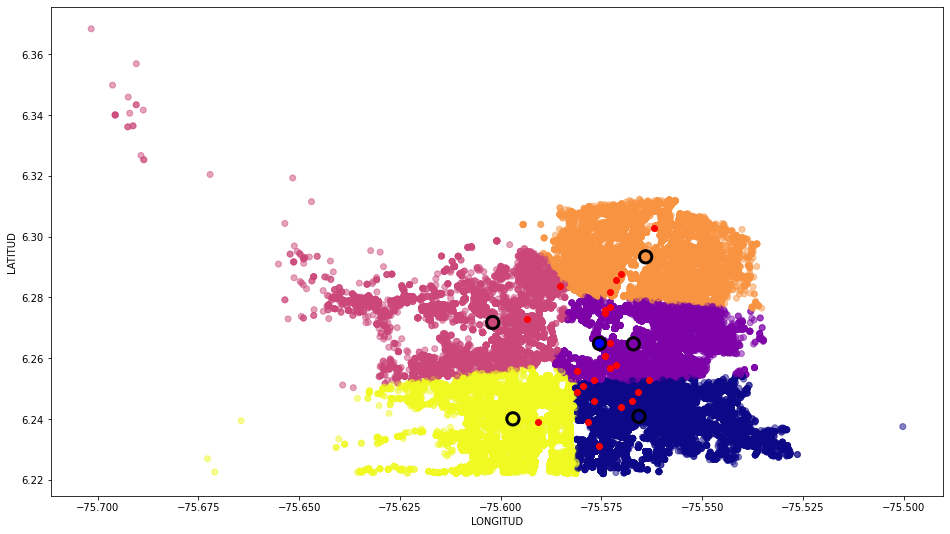

In [16]:
plt.figure(figsize = (16, 9))
n_clusters = len(np.unique(y_pred))

cmap = plt.cm.plasma
plt.scatter(x_LatLon[:,0], x_LatLon[:, 1], color=cmap((y_pred*255./(n_clusters-1)).astype(int)), alpha=.5)

plt.scatter(cluster_centers[:,0], cluster_centers[:,1], s=150,  lw=3,
                    facecolor=cmap((np.arange(n_clusters)*255./(n_clusters-1)).astype(int)),
                    edgecolor="black")   
plt.scatter(x_lonHighest, y_latHighest, color = "red")
plt.scatter(x_lonHighest[0], y_latHighest[0], color = "blue", s = 150, lw = 3, edgecolor = "black")


plt.xlabel('LONGITUD')
plt.ylabel('LATITUD')

fname='clusters_acc_med.pdf'
plt.savefig(fname)

plt.show()

In [17]:
for i in cluster_centers:
  folium.Marker(location=[i[1], i[0]], 
                popup=f"Cluster center",
                icon=folium.Icon(color='black', icon='info-sign')
               ).add_to(map)

map.save('map_accidents_med.html')
map

In [16]:
data = data.drop('DIRECCION', axis=1)
data.head()

,HORA,DIA_NOMBRE,PERIODO,CLASE,TIPO_GEOCOD,GRAVEDAD,DISENO,MES,DIA,FECHA,MES_NOMBRE,LONGITUD,LATITUD
0,01:35:00,MIÉRCOLES,2020,Choque,Malla vial,CON HERIDOS,Tramo de via,7,1,2020/07/01 00:00:00+00,JULIO,-75.568507,6.210703
1,11:30:00,VIERNES,2020,Choque,Malla vial,SOLO DAÑOS,Tramo de via,5,8,2020/05/08 00:00:00+00,MAYO,-75.558959,6.244545
2,08:25:00,LUNES,2020,Otro,Malla vial,SOLO DAÑOS,Tramo de via,10,19,2020/10/19 00:00:00+00,OCTUBRE,-75.575041,6.253081
3,06:30:00,MIÉRCOLES,2020,Choque,No Ubicada,CON HERIDOS,Interseccion,7,15,2020/07/15 00:00:00+00,JULIO,-75.703816,6.221806
4,02:00:00,DOMINGO,2020,Choque,Malla vial,CON HERIDOS,Tramo de via,4,5,2020/04/05 00:00:00+00,ABRIL,-75.576423,6.253848


In [17]:
print("Integral todos los años \n\n", data['GRAVEDAD'].value_counts(), "\n")

for _, ind in enumerate(data['PERIODO'].value_counts().index[:]):
  print(ind)
  print(data[(data['PERIODO'] == ind)]['GRAVEDAD'].value_counts(), "\n")

Integral todos los años 

 SOLO DAÑOS     39254
HERIDO         37322
CON HERIDOS    18866
MUERTO           291
CON MUERTOS      183
Name: GRAVEDAD, dtype: int64 

2021
HERIDO        23651
SOLO DAÑOS    16786
MUERTO          162
Name: GRAVEDAD, dtype: int64 

2020
CON HERIDOS    18866
SOLO DAÑOS     12691
CON MUERTOS      183
Name: GRAVEDAD, dtype: int64 

2022
HERIDO        13671
SOLO DAÑOS     9777
MUERTO          129
Name: GRAVEDAD, dtype: int64 



In [22]:
data['GRAVEDAD'] = data['GRAVEDAD'].replace('HERIDO', 'HERIDOS')
data['GRAVEDAD'] = data['GRAVEDAD'].replace('CON HERIDOS', 'HERIDOS')

data['GRAVEDAD'] = data['GRAVEDAD'].replace('MUERTO', 'MUERTOS')
data['GRAVEDAD'] = data['GRAVEDAD'].replace('CON MUERTOS', 'MUERTOS')

print(data['GRAVEDAD'].value_counts())


dummies = pd.get_dummies(data['GRAVEDAD'])
data = data.join(dummies)
data.head()

HERIDOS       56188
SOLO DAÑOS    39254
MUERTOS         474
Name: GRAVEDAD, dtype: int64


,HORA,DIA_NOMBRE,PERIODO,CLASE,TIPO_GEOCOD,GRAVEDAD,DISENO,MES,DIA,FECHA,MES_NOMBRE,LONGITUD,LATITUD,HERIDOS,MUERTOS,SOLO DAÑOS
0,01:35:00,MIÉRCOLES,2020,Choque,Malla vial,HERIDOS,Tramo de via,7,1,2020/07/01 00:00:00+00,JULIO,-75.568507,6.210703,1,0,0
1,11:30:00,VIERNES,2020,Choque,Malla vial,SOLO DAÑOS,Tramo de via,5,8,2020/05/08 00:00:00+00,MAYO,-75.558959,6.244545,0,0,1
2,08:25:00,LUNES,2020,Otro,Malla vial,SOLO DAÑOS,Tramo de via,10,19,2020/10/19 00:00:00+00,OCTUBRE,-75.575041,6.253081,0,0,1
3,06:30:00,MIÉRCOLES,2020,Choque,No Ubicada,HERIDOS,Interseccion,7,15,2020/07/15 00:00:00+00,JULIO,-75.703816,6.221806,1,0,0
4,02:00:00,DOMINGO,2020,Choque,Malla vial,HERIDOS,Tramo de via,4,5,2020/04/05 00:00:00+00,ABRIL,-75.576423,6.253848,1,0,0


In [23]:
print(data['CLASE'].value_counts())

dummies = pd.get_dummies(data['CLASE'])
data = data.join(dummies)
data.head()

Choque            61865
Otro              14676
Atropello          8582
Caida Ocupante     5676
Volcamiento        5103
Incendio             14
Name: CLASE, dtype: int64


,HORA,DIA_NOMBRE,PERIODO,CLASE,TIPO_GEOCOD,GRAVEDAD,DISENO,MES,DIA,FECHA,...,LATITUD,HERIDOS,MUERTOS,SOLO DAÑOS,Atropello,Caida Ocupante,Choque,Incendio,Otro,Volcamiento
0,01:35:00,MIÉRCOLES,2020,Choque,Malla vial,HERIDOS,Tramo de via,7,1,2020/07/01 00:00:00+00,...,6.210703,1,0,0,0,0,1,0,0,0
1,11:30:00,VIERNES,2020,Choque,Malla vial,SOLO DAÑOS,Tramo de via,5,8,2020/05/08 00:00:00+00,...,6.244545,0,0,1,0,0,1,0,0,0
2,08:25:00,LUNES,2020,Otro,Malla vial,SOLO DAÑOS,Tramo de via,10,19,2020/10/19 00:00:00+00,...,6.253081,0,0,1,0,0,0,0,1,0
3,06:30:00,MIÉRCOLES,2020,Choque,No Ubicada,HERIDOS,Interseccion,7,15,2020/07/15 00:00:00+00,...,6.221806,1,0,0,0,0,1,0,0,0
4,02:00:00,DOMINGO,2020,Choque,Malla vial,HERIDOS,Tramo de via,4,5,2020/04/05 00:00:00+00,...,6.253848,1,0,0,0,0,1,0,0,0


In [24]:
print(data['DISENO'].value_counts())

dummies = pd.get_dummies(data['DISENO'])
data = data.join(dummies)
data.head()

Tramo de via     52200
Lote o Predio    21359
Interseccion     18493
Glorieta          1949
Paso Elevado       521
Puente             421
Ciclo Ruta         387
Paso Inferior      386
Tunel              129
Paso a Nivel        50
Via peatonal        11
Pontón              10
Name: DISENO, dtype: int64


,HORA,DIA_NOMBRE,PERIODO,CLASE,TIPO_GEOCOD,GRAVEDAD,DISENO,MES,DIA,FECHA,...,Interseccion,Lote o Predio,Paso Elevado,Paso Inferior,Paso a Nivel,Pontón,Puente,Tramo de via,Tunel,Via peatonal
0,01:35:00,MIÉRCOLES,2020,Choque,Malla vial,HERIDOS,Tramo de via,7,1,2020/07/01 00:00:00+00,...,0,0,0,0,0,0,0,1,0,0
1,11:30:00,VIERNES,2020,Choque,Malla vial,SOLO DAÑOS,Tramo de via,5,8,2020/05/08 00:00:00+00,...,0,0,0,0,0,0,0,1,0,0
2,08:25:00,LUNES,2020,Otro,Malla vial,SOLO DAÑOS,Tramo de via,10,19,2020/10/19 00:00:00+00,...,0,0,0,0,0,0,0,1,0,0
3,06:30:00,MIÉRCOLES,2020,Choque,No Ubicada,HERIDOS,Interseccion,7,15,2020/07/15 00:00:00+00,...,1,0,0,0,0,0,0,0,0,0
4,02:00:00,DOMINGO,2020,Choque,Malla vial,HERIDOS,Tramo de via,4,5,2020/04/05 00:00:00+00,...,0,0,0,0,0,0,0,1,0,0


In [446]:
grouped_day = data.groupby(['MES', 'DIA']).size().reset_index(name='day_count')
grouped_day

,MES,DIA,day_count
0,1,1,186
1,1,2,186
2,1,3,258
3,1,4,277
4,1,5,218
...,...,...,...
361,12,27,163
362,12,28,198
363,12,29,168
364,12,30,237


In [447]:
grouped_month = data.groupby(['MES']).size().reset_index(name='total_count')
grouped_month

,MES,total_count
0,1,9175
1,2,10779
2,3,9735
3,4,6761
4,5,8557
5,6,9180
6,7,8801
7,8,6012
8,9,6631
9,10,6564


In [448]:
# Grouping by day => year month dia day_counts
grouped_day = data.groupby(['MES', 'DIA']).size().reset_index(name='day_count')

# Grouping by month => year mes month_counts
grouped_month = data.groupby(['MES']).size().reset_index(name='total_count')

# merging together => mes dia day_counts month_counts
ratio_dayMonth = pd.merge(grouped_day, grouped_month, on='MES')

# Calculating the ratio
ratio_dayMonth['ratio'] = 100.*result['day_count'] / result['total_count']
ratio_dayMonth = ratio_dayMonth.groupby('DIA')['ratio'].mean().reset_index()
ratio_dayMonth

,DIA,ratio
0,1,3.108515
1,2,3.134273
2,3,3.440900
3,4,3.309126
4,5,3.240390
5,6,3.478294
6,7,3.316529
7,8,3.192189
8,9,3.286997
9,10,3.277499


In [450]:
ratio_monthYear = data.groupby(['MES']).size().reset_index(name = 'month_count')
ratio_monthYear['ratio'] = 100.*ratio_monthYear['month_count'] / ratio_monthYear['month_count'].sum()
ratio_monthYear

,MES,month_count,ratio
0,1,9175,9.565662
1,2,10779,11.237958
2,3,9735,10.149506
3,4,6761,7.048876
4,5,8557,8.921348
5,6,9180,9.570875
6,7,8801,9.175737
7,8,6012,6.267984
8,9,6631,6.913341
9,10,6564,6.843488


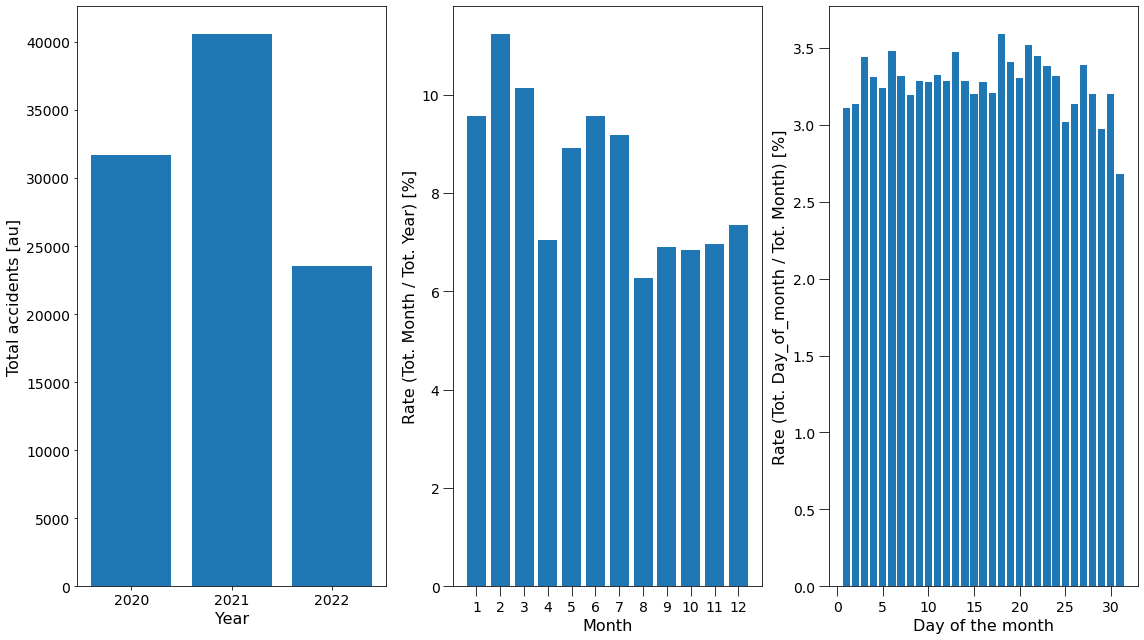

In [451]:
fig, axes = plt.subplots(1, 3, figsize=(16, 9))

axes = axes.flatten()

for i in range(3):  
  ax = axes[i]
  if i == 0:
    cnts = data['PERIODO'].value_counts()
    ax.bar(cnts.index[:], cnts)
    ax.set_xlabel("Year", fontsize = 16)
    ax.set_ylabel("Total accidents [au]", fontsize = 16)
    ax.set_xticks(data['PERIODO'].value_counts().index[:])
    
  elif i == 1:    
    ax.bar(ratio_monthYear['MES'], ratio_monthYear['ratio'])
    ax.set_xlabel("Month", fontsize = 16)
    ax.set_ylabel("Rate (Tot. Month / Tot. Year) [%]", fontsize = 16)
    ax.set_xticks(ratio_monthYear['MES'])
    ax.tick_params(axis = 'both', length = 10)    
    
  elif i == 2:
    ax.bar(ratio_dayMonth['DIA'], ratio_dayMonth['ratio'])
    ax.set_xlabel("Day of the month", fontsize = 16)        
    ax.tick_params(axis = 'both', length = 10)
    ax.set_ylabel("Rate (Tot. Day_of_month / Tot. Month) [%]", fontsize = 16)
    
  ax.tick_params(axis = 'both', labelsize = 14)
    
  
plt.tight_layout()
plt.show()

In [403]:
ratio_dayMonth['ratio']

0      2.027248
1      2.027248
2      2.811989
3      3.019074
4      2.376022
         ...   
361    2.313369
362    2.810105
363    2.384332
364    3.363611
365    2.270792
Name: ratio, Length: 366, dtype: float64

In [37]:
data['GRAVEDAD'].value_counts()

HERIDOS       56188
SOLO DAÑOS    39254
MUERTOS         474
Name: GRAVEDAD, dtype: int64

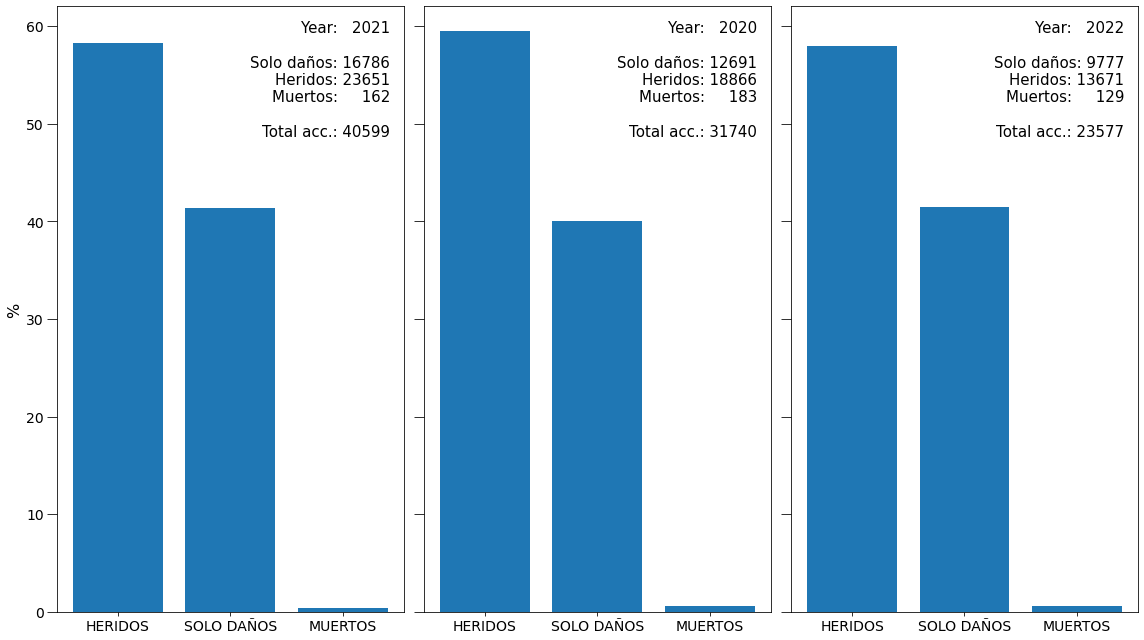

In [305]:
fig, axes = plt.subplots(1, 3, figsize=(16, 9))
axes = axes.flatten()

for i, ind in enumerate(data['PERIODO'].value_counts().index[:]):
  ax = axes[i]
  cnts = data[(data['PERIODO'] == ind)]['GRAVEDAD'].value_counts()
  cnts_norm = 100.*cnts / np.sum(cnts)
  ax.bar(cnts_norm.index[:], cnts_norm, label = "Year:   " + str(ind) \
         + "\n\nSolo daños: " + str(cnts[1]) + "\n"
         + "Heridos: " + str(cnts[0]) + "\n"
         + "Muertos:     " + str(cnts[2]) + "\n\n"
         + "Total acc.: " + str(np.sum(cnts)) + "\n")
         
  ax.legend(handletextpad = 0., handlelength = 0, frameon = False, fontsize = 15).get_texts()[0].set_ha('right')
  ax.tick_params(axis = 'x', labelsize = 14)  
  ax.tick_params(axis = 'y', length = 10)
  ax.set_ylim(ymax = 62)
  
  if i == 0:
    ax.tick_params(axis='both', labelsize=14)    
    ax.set_ylabel("%", fontsize = 16)
  else:
    ax.set_yticklabels([])    
    
plt.tight_layout()
plt.show()

In [281]:
data2 = pd.read_csv('data/incidentes_viales.csv', delimiter = ';')

<ipython-input-281-ea9b5747f48a>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data2 = pd.read_csv('data/incidentes_viales.csv', delimiter = ';')


In [282]:
data2.head()

,AÑO,CBML,CLASE_ACCIDENTE,DIRECCION,DIRECCION ENCASILLADA,DISEÑO,EXPEDIENTE,FECHA_ACCIDENTE,FECHA_ACCIDENTES,GRAVEDAD_ACCIDENTE,MES,NRO_RADICADO,NUMCOMUNA,BARRIO,COMUNA,LOCATION,X,Y
0,2015,1013,Caida Ocupante,CR 46 CL 43,CR 046 043 000 00000,Tramo de via,A000259731,21/10/2015 05:58:00,2015-10-21T10:58:00.000Z,Con heridos,10,1508668,10,Barrio Colón,La Candelaria,"[-75.5688011014, 6.24312304123]",834949.69,1182357.34
1,2015,1020,Choque,CR 43 A CL 29,CR 043 A 029 000 00000,Tramo de via,A000261725,05/11/2015 03:00:00,2015-11-05T08:00:00.000Z,Solo daños,11,1510621,10,San Diego,La Candelaria,"[-75.5693883283, 6.22870030622]",834880.17,1180762.02
2,2015,0205,Otro,CR 46 CL 37,CR 046 037 000 00000,Tramo de via,A000259739,21/10/2015 07:40:00,2015-10-21T12:40:00.000Z,Con heridos,10,1508691,02,La Francia,Santa Cruz,"[-75.5503911403, 6.29869502502]",837004.94,1188499.17
3,2015,0101,Atropello,CR 34 CL 112,CR 034 112 000 00000,Tramo de via,A000259752,21/10/2015 12:00:00,2015-10-21T17:00:00.000Z,Con heridos,10,1508694,01,Santo Domingo Savio No. 1,Popular,"[-75.5442195069, 6.30019383306]",837688.53,1188663.05
4,2015,1504,Choque,CR 50 CL 14,CR 050 014 000 00000,Tramo de via,A000259949,03/11/2015 06:16:00,2015-11-03T11:16:00.000Z,Solo daños,11,1510634,15,Santa Fé,Guayabal,"[-75.578180998, 6.21699243701]",833903.11,1179469.60


In [286]:
data[data['PERIODO'] == 2020]['MES'].value_counts()

2     4069
1     3744
12    3345
11    3016
9     2835
10    2827
3     2652
8     2270
6     2191
7     2152
5     1741
4      898
Name: MES, dtype: int64

In [287]:
data2[(data2['AÑO'] == 2020)]['MES'].value_counts()

2    2021
3    1795
8    1516
6    1485
7    1431
1    1220
5    1144
4     601
Name: MES, dtype: int64

In [291]:
data2['AÑO'].value_counts()

2018      39897
2016      35250
2015      31356
2017      28039
2019\r    26760
2019      19035
2017      18166
2014      14936
2015      14816
2016      11853
2020      11213
2020       8504
2014       7479
2018       3461
Name: AÑO, dtype: int64

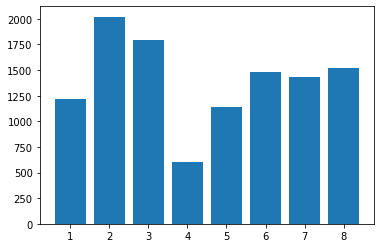

In [285]:
cnts = data2[(data2['AÑO'] == 2020)]['MES'].value_counts()
plt.bar(cnts.index[:], cnts)

plt.show()

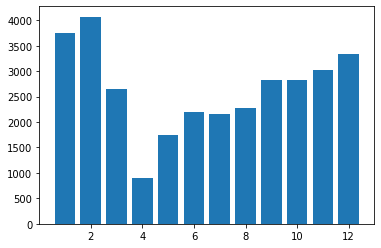

In [295]:
cnts = data[(data['PERIODO'] == 2020)]['MES'].value_counts()
plt.bar(cnts.index[:], cnts)

plt.show()

In [300]:
data2['FECHA_ACCIDENTE'] = pd.to_datetime(data2['FECHA_ACCIDENTE'], format = '%d/%m/%Y %H:%M:%S', errors='coerce')

data2['Day'] = data2['FECHA_ACCIDENTE'].dt.day
data2.head()

,AÑO,CBML,CLASE_ACCIDENTE,DIRECCION,DIRECCION ENCASILLADA,DISEÑO,EXPEDIENTE,FECHA_ACCIDENTE,FECHA_ACCIDENTES,GRAVEDAD_ACCIDENTE,MES,NRO_RADICADO,NUMCOMUNA,BARRIO,COMUNA,LOCATION,X,Y,Day
0,2015,1013,Caida Ocupante,CR 46 CL 43,CR 046 043 000 00000,Tramo de via,A000259731,2015-10-21 05:58:00,2015-10-21T10:58:00.000Z,Con heridos,10,1508668,10,Barrio Colón,La Candelaria,"[-75.5688011014, 6.24312304123]",834949.69,1182357.34,21.0
1,2015,1020,Choque,CR 43 A CL 29,CR 043 A 029 000 00000,Tramo de via,A000261725,2015-11-05 03:00:00,2015-11-05T08:00:00.000Z,Solo daños,11,1510621,10,San Diego,La Candelaria,"[-75.5693883283, 6.22870030622]",834880.17,1180762.02,5.0
2,2015,0205,Otro,CR 46 CL 37,CR 046 037 000 00000,Tramo de via,A000259739,2015-10-21 07:40:00,2015-10-21T12:40:00.000Z,Con heridos,10,1508691,02,La Francia,Santa Cruz,"[-75.5503911403, 6.29869502502]",837004.94,1188499.17,21.0
3,2015,0101,Atropello,CR 34 CL 112,CR 034 112 000 00000,Tramo de via,A000259752,2015-10-21 12:00:00,2015-10-21T17:00:00.000Z,Con heridos,10,1508694,01,Santo Domingo Savio No. 1,Popular,"[-75.5442195069, 6.30019383306]",837688.53,1188663.05,21.0
4,2015,1504,Choque,CR 50 CL 14,CR 050 014 000 00000,Tramo de via,A000259949,2015-11-03 06:16:00,2015-11-03T11:16:00.000Z,Solo daños,11,1510634,15,Santa Fé,Guayabal,"[-75.578180998, 6.21699243701]",833903.11,1179469.60,3.0


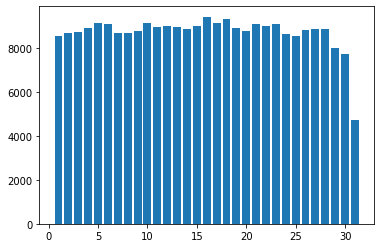

In [303]:
cnts = data2['Day'].value_counts()

plt.bar(cnts.index[:], cnts)
plt.show()